In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gradio_new

state = gradio_new.get_state()

/opt/conda/envs/zero123/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instantiating LatentDiffusion...

Loading model from 105000.ckpt

Global Step: 105000

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Instantiating Carvekit HiInterface...

Instantiating StableDiffusionSafetyChecker...

Instantiating AutoFeatureExtractor...

In [3]:
from PIL import Image
i = 103
filepath = (
        f'/home/jupyter/pixel-nerf/data_root/'
        f'rs_dtu_4/DTU/scan{i}/image/000000.png')
raw_im = Image.open(filepath)
raw_im = raw_im.convert('RGBA')
raw_im = gradio_new.central_crop(raw_im)

output_ims = gradio_new.main_run_v2(
    state['models'],
    state['device'],
    raw_im=raw_im,
    preprocess=True
)

old input_im:
(300, 300)

Infer foreground mask (preprocess_image) took 0.006s.

new input_im: array[256, 256, 3] f32 n=196608 (0.8Mb) x∈[0.047, 1.000] μ=0.615 σ=0.320

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


torch.Size([1, 4, 32, 32])

In [36]:
import os
from tqdm import tqdm
from glob import glob
import numpy as np
import os

rescale=True
import skimage.measure
from skimage.metrics import structural_similarity, peak_signal_noise_ratio


psnrs = []
ssims = []

for scan in tqdm(range(1, 128)):
    scan = 103
    scan_dir = (
        f'/home/jupyter/pixel-nerf/data_root/'
        f'rs_dtu_4/DTU/scan{scan}/image/')
    if not os.path.exists(scan_dir):
        continue
    scan_paths = set(glob(os.path.join(scan_dir, '*.png')))
    
    cameras_path = (
        f'/home/jupyter/pixel-nerf/data_root/'
        f'rs_dtu_4/DTU/scan{scan}/cameras.npz')
    cameras = dict(np.load(cameras_path))
    
    points = np.array([gradio_new.get_pose(cameras, i)[:3, -1] for i in range(len(scan_paths))])
    mean_norm = np.sqrt((points**2).sum(axis=-1)).mean()
    
    # all_intrinsics = np.array([cameras[f'scale_mat_{i}'] for i in range(len(scan_paths))])
     
    
    # verify that intrinsics are constant
    # assert (all_intrinsics.std(axis=0).ravel() < 1e-8).all()
    # main_intrinsics = all_intrinsics[0]
    # main_extrinsics = cameras[f'world_mat_inv_25']
    main_extrinsics = gradio_new.get_pose(cameras, 25)
    
    if rescale:
        main_extrinsics[:3,-1] = main_extrinsics[:3,-1] / mean_norm
    
    
    src_scan_path = os.path.join(scan_dir, "000025.png")
    
    src_scan_im = Image.open(src_scan_path)
    src_scan_im = src_scan_im.convert('RGBA')
    src_scan_im = gradio_new.central_crop(src_scan_im)
    
    # dst_scan_paths = set(scan_paths) - {src_scan_path}
    dst_scan_paths = set(scan_paths)
    assert src_scan_path in scan_paths
    # assert src_scan_path not in dst_scan_paths
    
    for dst_scan_path in dst_scan_paths:
        idx = gradio_new.get_idx(dst_scan_path)

        if idx != 25:
            continue
        # subsample = 1/20
        # if np.random.uniform() >= subsample:
        #     continue
            
        novel_extrinsics = gradio_new.get_pose(cameras, idx)
        if rescale:
            novel_extrinsics[:3,-1] = novel_extrinsics[:3,-1] / mean_norm
        
        relative_novel_extrinsics = np.matmul(np.linalg.inv(main_extrinsics), novel_extrinsics)
        # import pdb
        # pdb.set_trace()
        relative_novel_extrinsics = relative_novel_extrinsics.copy()
        camera_loc = relative_novel_extrinsics[:3, -1].copy()
        camera_loc += np.array([1., 0, 0])

        polar_deg, azimuth_deg, radius = gradio_new.inv_get_camera_loc(camera_loc.copy())
        print(polar_deg, azimuth_deg, radius)
        adjusted_radius = radius - 1
        
        [dst_im_pred] = gradio_new.main_run_v2(
            state['models'],
            state['device'],
            raw_im=src_scan_im,
            preprocess=False,
            x=np.float32(polar_deg),
            y=np.float32(azimuth_deg),
            z=np.float32(adjusted_radius)
        )
        dst_im_gt = Image.open(dst_scan_path)
        # dst_im_gt = dst_im_gt.convert('RGBA')
        dst_im_gt = gradio_new.central_crop(dst_im_gt).resize(dst_im_pred.size)
        
        ssim = structural_similarity(
            np.array(dst_im_pred)[..., :3]/255,
            np.array(dst_im_gt)[..., :3]/255,
            channel_axis=-1, data_range=1)
        ssims.append(ssim)

        psnr = peak_signal_noise_ratio(
            np.array(dst_im_gt)[..., :3]/255,
            np.array(dst_im_pred)[..., :3]/255,
            data_range=1)
        psnrs.append(psnr)
        raise
        
print(np.mean(psnrs), np.mean(ssims))

  0%|          | 0/127 [00:00<?, ?it/s]

-4.325711002747335e-06 0.0 1.0


old input_im:
(300, 300)

Infer foreground mask (preprocess_image) took 0.006s.

new input_im: array[256, 256, 3] f32 n=196608 (0.8Mb) x∈[0.008, 1.000] μ=0.465 σ=0.286

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


torch.Size([1, 4, 32, 32])

  0%|          | 0/127 [00:04<?, ?it/s]


RuntimeError: No active exception to reraise

In [20]:
print(np.mean(psnrs), np.mean(ssims))

5.801148707662551 0.1535990838497503


In [381]:
!ls /home/jupyter/pixel-nerf/data_root/rs_dtu_4/DTU/

mvsnet_test.lst   scan109  scan124  scan24  scan4   scan55  scan70  scan9
mvsnet_train.lst  scan11   scan125  scan25  scan40  scan56  scan71  scan90
mvsnet_val.lst	  scan110  scan126  scan26  scan41  scan57  scan72  scan91
new_test.lst	  scan111  scan127  scan27  scan42  scan58  scan73  scan92
new_train.lst	  scan112  scan128  scan28  scan43  scan59  scan74  scan93
new_val.lst	  scan113  scan13   scan29  scan44  scan6   scan75  scan94
scan1		  scan114  scan14   scan3   scan45  scan60  scan76  scan95
scan10		  scan115  scan15   scan30  scan46  scan61  scan77  scan96
scan100		  scan116  scan16   scan31  scan47  scan62  scan8   scan97
scan101		  scan117  scan17   scan32  scan48  scan63  scan82  scan98
scan102		  scan118  scan18   scan33  scan49  scan64  scan83  scan99
scan103		  scan119  scan19   scan34  scan5   scan65  scan84  test.lst
scan104		  scan12   scan2    scan35  scan50  scan66  scan85  train.lst
scan105		  scan120  scan20   scan36  scan51  scan67  scan86  val.lst
scan106		  sca

In [30]:
ssim = structural_similarity(
    np.array(dst_im_pred)[..., :3]/255,
    np.array(dst_im_gt)[..., :3]/255,
    channel_axis=-1, data_range=1)

psnr = peak_signal_noise_ratio(
    np.array(dst_im_gt)[..., :3]/255,
    np.array(dst_im_pred)[..., :3]/255,
    data_range=1)
ssim, psnr

(0.506571639751814, 18.01401938031394)

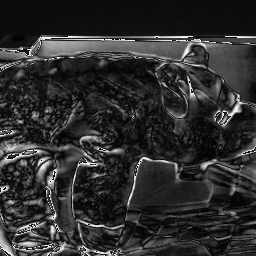

In [28]:
diff = np.array(dst_im_pred)/255 - np.array(dst_im_gt)/255
diff = np.abs(diff).sum(axis=-1)*255
Image.fromarray(diff.astype(np.uint8))

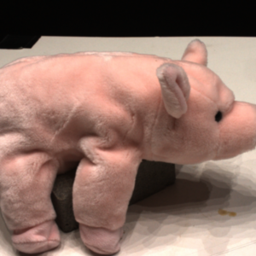

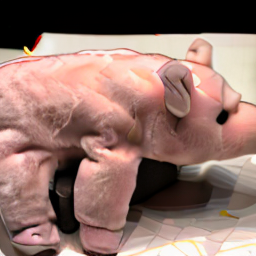

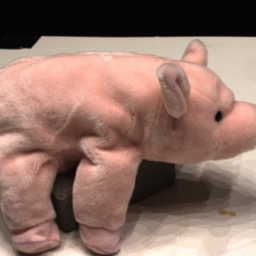

In [37]:
display(src_scan_im.resize((256, 256)))
display(dst_im_pred.resize((256, 256)))
display(dst_im_gt.resize((256, 256)))

In [349]:
cv2.PSNR(

<function PSNR>

In [313]:
main_extrinsics.round(3).tolist()

[[0.671999990940094,
  0.24500000476837158,
  -0.6990000009536743,
  0.7409999966621399],
 [-0.6150000095367432,
  0.7099999785423279,
  -0.34200000762939453,
  0.33899998664855957],
 [0.4129999876022339,
  0.6600000262260437,
  0.628000020980835,
  -0.6159999966621399],
 [0.0, 0.0, 0.0, 1.0]]

In [262]:
novel_extrinsics[:3,-1] = novel_extrinsics[:3,-1] / mean_norm

In [226]:
relative_novel_extrinsics.round(4).tolist()
# relative_novel_extrinsics = np.matmul(np.linalg.inv(main_extrinsics), novel_extrinsics)
# relative_novel_extrinsics.round(4).tolist()


[[1.0, 0.0, -0.0, 0.0],
 [0.0, 1.0, -0.0, -0.0],
 [-0.0, 0.0, 1.0, -0.0],
 [0.0, 0.0, 0.0, 1.0]]

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

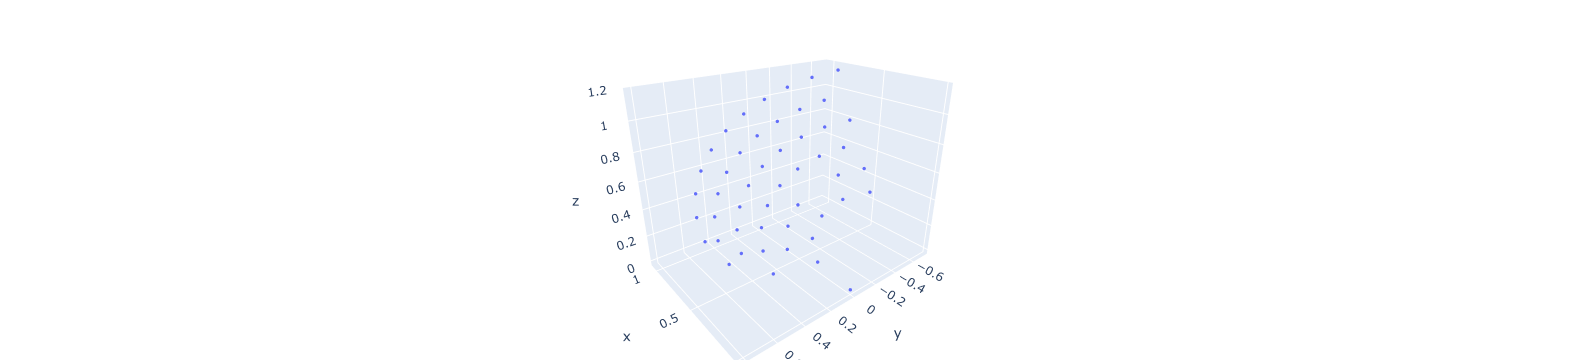

In [167]:

points = np.array([cameras[f'world_mat_inv_{i}'][:3, -1] for i in range(49)])
mean_norm = np.sqrt((points**2).sum(axis=-1)).mean()
points /= mean_norm
visu3d.make_fig(visu3d.Point3d(p=points))

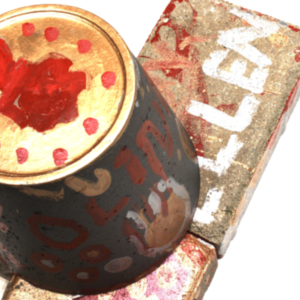

In [47]:
import gradio_new

gradio_new.central_crop(raw_im)

In [31]:
gradio_new.sys.argv = []
gradio_new.run_demo()

sys.argv:
[]

Instantiating LatentDiffusion...

Loading model from 105000.ckpt

Global Step: 105000

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Instantiating Carvekit HiInterface...

Instantiating StableDiffusionSafetyChecker...

Instantiating AutoFeatureExtractor...

/opt/conda/envs/zero123/lib/python3.9/site-packages/gradio/blocks.py:1381: DeprecationWarning: The `enable_queue` parameter has been deprecated. Please use the `.queue()` method instead.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://cd4a594f6d68118fbd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1


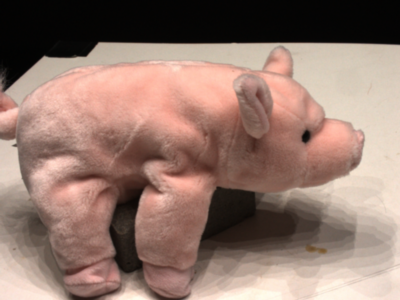

RuntimeError: No active exception to reraise

has_nsfw_concept:
[False]

Safety check passed.

old input_im:
(400, 300)

Infer foreground mask (preprocess_image) took 0.239s.

new input_im: array[256, 256, 3] f32 n=196608 (0.8Mb) x∈[0., 1.000] μ=0.873 σ=0.234

x: array[256, 256] n=65536 (0.5Mb) [38;2;127;127;127mall_zeros[0m

y: array[256, 256] n=65536 (0.5Mb) x∈[-1.000, 1.000] μ=0. σ=0.580

z: array[256, 256] n=65536 (0.5Mb) x∈[-1.000, 1.000] μ=2.776e-17 σ=0.580

Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 76 timesteps


torch.Size([4, 4, 32, 32])

In [33]:
from PIL import Image
for i in range(1,129):
    filepath = (
        f'/home/jupyter/pixel-nerf/data_root/'
        f'rs_dtu_4/DTU/scan103/image/000025.png')
    if os.path.exists(filepath):
        print(i)
        # display(Image.open(filepath).resize((128,128)))
        display(Image.open(filepath))
        raise
    # if i % 20 == 0:
    #     break
            
    

['astronaut', 'binary_blobs', 'brain', 'brick', 'camera', 'cat', 'cell', 'cells3d', 'checkerboard', 'chelsea', 'clock', 'coffee', 'coins', 'colorwheel', 'create_image_fetcher', 'data_dir', 'download_all', 'eagle', 'file_hash', 'grass', 'gravel', 'horse', 'hubble_deep_field', 'human_mitosis', 'image_fetcher', 'immunohistochemistry', 'kidney', 'lbp_frontal_face_cascade_filename', 'lfw_subset', 'lily', 'logo', 'microaneurysms', 'moon', 'nickel_solidification', 'page', 'protein_transport', 'retina', 'rocket', 'shepp_logan_phantom', 'skin', 'stereo_motorcycle', 'text', 'vortex']


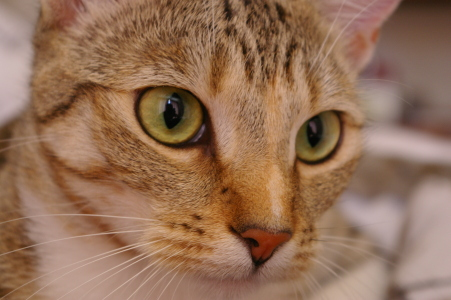

In [35]:
import skimage

print(dir(skimage.data))
Image.fromarray(skimage.data.cat())

In [36]:
import numpy as np

i = 9
camera_path = (
    f'/home/jupyter/pixel-nerf/data_root/'
    f'rs_dtu_4/DTU/scan{i}/cameras.npz')

cameras = dict(np.load(camera_path))



[array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
        [  0. ,   0. , 300. , 653.2],
        [  0. ,   0. ,   0. ,   1. ]]),
 array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
        [  0. ,   0. , 300. , 653.2],
        [  0. ,   0. ,   0. ,   1. ]]),
 array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
        [  0. ,   0. , 300. , 653.2],
        [  0. ,   0. ,   0. ,   1. ]]),
 array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
        [  0. ,   0. , 300. , 653.2],
        [  0. ,   0. ,   0. ,   1. ]]),
 array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
        [  0. ,   0. , 300. , 653.2],
        [  0. ,   0. ,   0. ,   1. ]]),
 array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
        [  0. ,   0. , 300. , 653.2],
        [  0. ,   0. ,   0. ,   1. ]]),
 array([[300. ,   0. ,   0. , -37.5],
        [  0. , 300. ,   0. , -42.6],
